In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, ShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set_style('whitegrid')
import re

In [162]:
#Import the data from excel
titanic_df = pd.read_csv('titanic_train.csv',
                        delimiter = ',',
                        index_col=None,
                        engine='python')

In [106]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [107]:
#Baseline Mean
titanic_df['Survived'].mean()

0.38383838383838381

In [108]:
titanic_df[['Survived','Age','Fare','Parch','SibSp','Pclass','Sex']].groupby(['Pclass','Sex']).mean()

Survived        Age        Fare     Parch     SibSp
Pclass Sex                                                        
1      female  0.968085  34.611765  106.125798  0.457447  0.553191
       male    0.368852  41.281386   67.226127  0.278689  0.311475
2      female  0.921053  28.722973   21.970121  0.605263  0.486842
       male    0.157407  30.740707   19.741782  0.222222  0.342593
3      female  0.500000  21.750000   16.118810  0.798611  0.895833
       male    0.135447  26.507589   12.661633  0.224784  0.498559

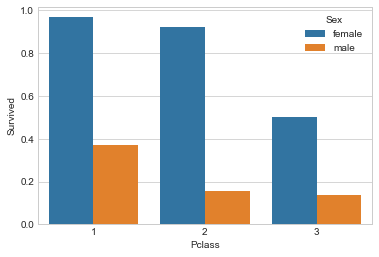

In [109]:
class_sex_grouping = titanic_df.groupby(['Pclass','Sex']).mean()
sns.barplot(x="Pclass",
            y="Survived",
            hue ='Sex',
            data=class_sex_grouping.reset_index())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


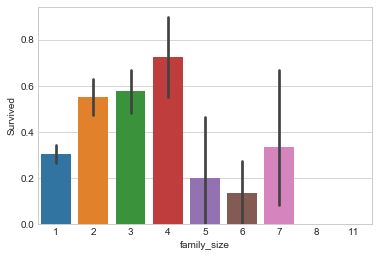

In [110]:
family_size = titanic_df[['Survived','Parch','SibSp']]
family_size['family_size'] = family_size['Parch']+family_size['SibSp'] +1
sns.barplot(x='family_size',y='Survived',data=family_size)

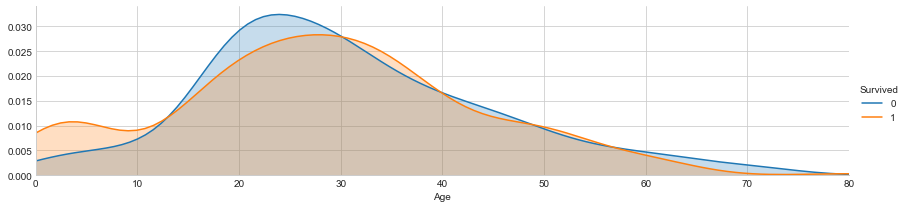

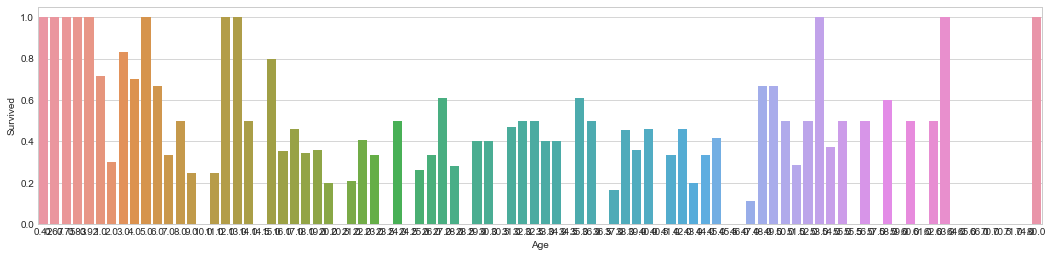

In [111]:
#Density by age
ages = sns.FacetGrid(titanic_df, hue='Survived', aspect = 4)
ages.map(sns.kdeplot, 'Age', shade = True)
ages.set(xlim=(0,titanic_df['Age'].max()))
ages.add_legend()
#Age and Survival Rate
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = titanic_df[['Age','Survived']].groupby(['Age'], as_index=False).mean()
sns.barplot(x='Age',y='Survived', data=average_age)

In [112]:
titanic_df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [163]:
# Create a function to preprocess the data
# Use label encoder to convert string data to integers
# Drop non-categorical data that would be difficult to encode
#def preprocess_titanic_df(df):
def process_df(titanic_df):
    processed_df = titanic_df.copy()
    processed_df.drop(['Cabin','Embarked','Ticket'], axis=1, inplace=True)
    le = LabelEncoder()
    processed_df['Sex'] = le.fit_transform(processed_df['Sex'])

    #Put age into bins

    processed_df['child'] = processed_df['Age'].map(lambda x: 1 if x < 17 else 0)
    processed_df['adult'] = processed_df['Age'].map(lambda x: 1 if 16 < x < 45 else 0)

    # Create dummy variables for Pclass, drop 3rd class
    pclass_dummies_titanic = pd.get_dummies(processed_df['Pclass'])
    pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
    pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)
    processed_df.join(pclass_dummies_titanic)
    processed_df = processed_df.join(pclass_dummies_titanic)

    # Small, Medium, Or Large Family
    processed_df['family_size'] = processed_df['SibSp'] + processed_df['Parch'] + 1
    processed_df['single'] = processed_df['family_size'].map(lambda s: 1 if s==1 else 0)
    processed_df['smallF'] = processed_df['family_size'].map(lambda s: 1 if s < 5 else 0)
    processed_df['medF'] = processed_df['family_size'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    processed_df['family_size'] = processed_df['family_size'].map(int)

    # Create titles from names
    name_title = processed_df['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
    processed_df['title'] = name_title
    
    #Fill in missing ages by title
    return processed_df

processed_df = process_df(titanic_df)
#Fill in missing ages
def fill_missing(processed_df):
    age_title = processed_df[['title','Age']].groupby('title').median()
    title_dict = age_title.reset_index().set_index('title')['Age'].to_dict()
    processed_df['Age']=processed_df['Age'].fillna(processed_df['title'].map(title_dict))
    
    fare_class = processed_df[['Pclass','Fare']].groupby('Pclass').median()
    fare_dict = fare_class.reset_index().set_index('Pclass')['Fare'].to_dict()
    processed_df['Fare']=processed_df['Fare'].fillna(processed_df['Pclass'].map(fare_dict))
    
    return processed_df
processed_df = fill_missing(processed_df)

In [115]:
def separate_titles(processed_df):
    lady = ['Lady','the Countess','Dona','Jonkheer','Ms','Mme','Mlle']
    sir = ['Don','Capt','Sir','Major','Col']
    middle = ['Dr','Rev']
    women = ['Mrs','Miss']
    master = ['Master']

    processed_df['title'].replace(lady,'lady',inplace=True)
    processed_df['title'].replace(sir,'sir',inplace=True)
    processed_df['title'].replace(middle,'middle_title',inplace=True)
    processed_df['title'].replace(women,'women',inplace=True)
    processed_df['title'].replace(master,'master',inplace=True)
    dummies = pd.get_dummies(processed_df['title'],drop_first=True)
    processed_df = processed_df.join(dummies)
    
    return processed_df

processed_df = separate_titles(processed_df)

In [116]:
processed_df['Fare'].describe()
processed_df.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Fare,child,adult,...,family_size,single,smallF,medF,title,lady,master,middle_title,sir,women
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,0,1,...,2,0,1,0,Mr,0,0,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,0,1,...,2,0,1,0,women,0,0,0,0,1
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,0,1,...,1,1,1,0,women,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,0,1,...,2,0,1,0,women,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,0,1,...,1,1,1,0,Mr,0,0,0,0,0


In [117]:
#sns.distplot(processed_df['fare'])
processed_df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

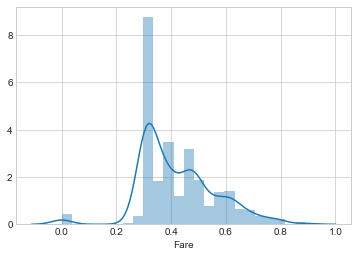

In [118]:
def norm_fare(processed_df):
    processed_df['Fare'] = np.log((1+processed_df['Fare']))/7
    return processed_df

processed_df = norm_fare(processed_df)
sns.distplot(processed_df['Fare'])

In [119]:
processed_df.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Fare,child,adult,...,family_size,single,smallF,medF,title,lady,master,middle_title,sir,women
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1,0,0.301459,0,1,...,2,0,1,0,Mr,0,0,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,0.611513,0,1,...,2,0,1,0,women,0,0,0,0,1
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0,0,0.312694,0,1,...,1,1,1,0,women,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,0.570119,0,1,...,2,0,1,0,women,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",1,35.0,0,0,0.314681,0,1,...,1,1,1,0,Mr,0,0,0,0,0


In [166]:
# drop extra columns
def drop_extra(processed_df):
    processed_df.drop(['SibSp',
                       'Parch',
                       'Age',
                       'Name',
                       'title',
                       'family_size',
                       'Pclass'
                   ], axis=1,inplace=True)
    return processed_df
processed_df=drop_extra(processed_df)
processed_df.head()

,PassengerId,Survived,Sex,Fare,child,adult,Class_1,Class_2,single,smallF,medF
0,1,0,1,7.2500,0,1,0,0,0,1,0
1,2,1,0,71.2833,0,1,1,0,0,1,0
2,3,1,0,7.9250,0,1,0,0,1,1,0
3,4,1,0,53.1000,0,1,1,0,0,1,0
4,5,0,1,8.0500,0,1,0,0,1,1,0


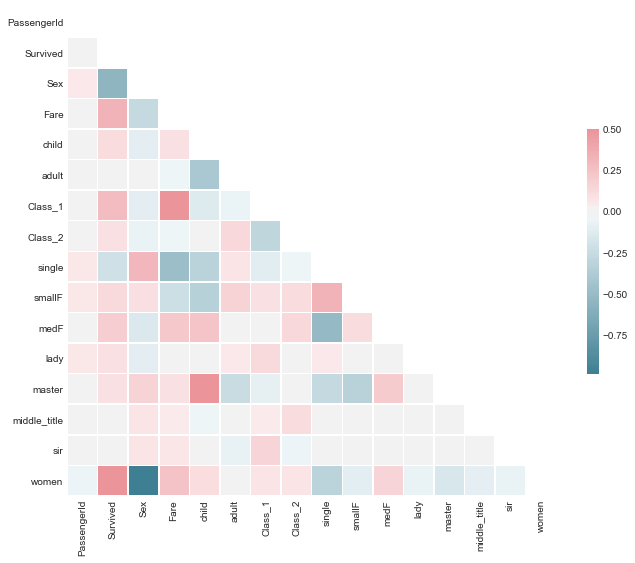

In [121]:
#Generate a correlation matrix between features
x_corr = processed_df.corr()
mask = np.zeros_like(x_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(x_corr, mask=mask, vmax=.5, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [122]:
# Set X and Y values
X = processed_df.drop(['Survived','PassengerId'], axis = 1).values
y = processed_df['Survived']

In [123]:
# Modeling step Test differents algorithms 
# Cross validate model with Kfold stratified cross val
shuffleSplit = ShuffleSplit(n_splits = 10, test_size=.2, random_state=0)

random_state = None
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
cv_results = []

In [124]:
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X, y = y, scoring = 'accuracy', cv = shuffleSplit, n_jobs=2, verbose =1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warn

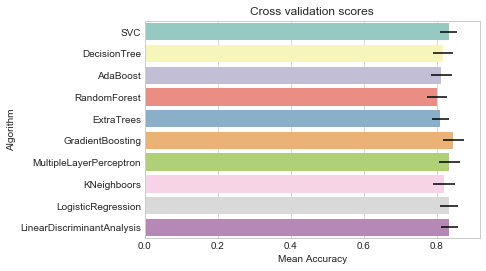

In [125]:
cv_res = pd.DataFrame(
    {"CrossValMeans":cv_means,
     "CrossValerrors": cv_std,
     "Algorithm":["SVC",
                  "DecisionTree",
                  "AdaBoost",
                  "RandomForest",
                  "ExtraTrees",
                  "GradientBoosting",
                  "MultipleLayerPerceptron",
                  "KNeighboors",
                  "LogisticRegression",
                  "LinearDiscriminantAnalysis"]})
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [126]:
#clf_dt = tree.DecisionTreeClassifier(max_depth=10)
cv_res

,Algorithm,CrossValMeans,CrossValerrors
0,SVC,0.832961,0.022686
1,DecisionTree,0.817318,0.026798
2,AdaBoost,0.812849,0.029056
3,RandomForest,0.801676,0.027168
4,ExtraTrees,0.810056,0.022762
5,GradientBoosting,0.846369,0.027624
6,MultipleLayerPerceptron,0.835196,0.029376
7,KNeighboors,0.819553,0.030090
8,LogisticRegression,0.834078,0.023444
9,LinearDiscriminantAnalysis,0.835196,0.023337


In [127]:
#Optimize top 5 algorithms, 
#LDA, 
#SVC, 
#MultipleLayerPerceptrion, 
#Gradient Boosting,
#Logistic Regression

In [128]:
# LDA Optimization
lda = LinearDiscriminantAnalysis()

In [129]:
#SVM Optimization
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=shuffleSplit, scoring="accuracy", n_jobs= 2, verbose = 1)

gsSVMC.fit(X,y)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 280 out of 280 | elapsed:   26.3s finished


0.83575418994413408

In [130]:
#MLPClassifier Optimization
mplc = MLPClassifier()
mplc_param_grid = {
                  'activation':['relu','tanh'],
                  }
gsMLPC = GridSearchCV(mplc,param_grid=mplc_param_grid,cv=shuffleSplit,scoring='accuracy',n_jobs=2,verbose=1)
gsMLPC.fit(X,y)
gsMLPC_best = gsMLPC.best_estimator_
#Best Score
gsMLPC.best_score_

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.2s finished


0.83184357541899445

In [181]:
#Gradient Boosting Optimization

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [3, 4, 8],
              #'min_samples_leaf': [100,150],
              'max_features': ['auto','log2',None] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=shuffleSplit, scoring="accuracy", n_jobs= 2, verbose = 1)

gsGBC.fit(X,y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:   10.6s
[Parallel(n_jobs=2)]: Done 291 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 541 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done 810 out of 810 | elapsed:  5.0min finished


0.85530726256983236

In [132]:
#Logistic Regression Optimization
lr = LogisticRegression()
#lr_param_grid = {'C': [1,10,50,100,200,300,1000]
               # }
#gslr = GridSearchCV(lr,param_grid =lr_param_grid,scoring='accuracy',n_jobs=2,verbose=1)
#gslr.fit(X,y)
lr_best = lr.fit(X,y)
#lr.best_score_

In [133]:
#Random Forest Optimization
clf_rf = RandomForestClassifier()
rf_param_grid = {'max_depth': [None],
                'max_features':[1,3,9],
                'min_samples_split': [2,3,9],
                'min_samples_leaf': [1,3,9],
                'bootstrap': [False],
                'n_estimators': [50,100,300],
                'criterion': ['gini']}
gsRFC = GridSearchCV(clf_rf, param_grid = rf_param_grid, cv=shuffleSplit, scoring='accuracy', n_jobs= 2, verbose = 1)
gsRFC.fit(X,y)
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=2)]: Done  61 tasks      | elapsed:   13.4s
[Parallel(n_jobs=2)]: Done 211 tasks      | elapsed:   43.0s
[Parallel(n_jobs=2)]: Done 461 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 810 out of 810 | elapsed:  2.6min finished


0.84972067039106147

In [188]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best),
('gbc',GBC_best)], voting='soft')

In [189]:
final_score = cross_val_score(votingC, X, y = y, 
                              scoring = 'accuracy', 
                              cv = shuffleSplit, 
                              verbose =1)
votingC.fit(X,y)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.6s finished


VotingClassifier(estimators=[('rfc', RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=2,
            min_weigh...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [190]:
print(final_score.mean())

0.854189944134


In [191]:
test = pd.read_csv('test.csv', delimiter=',',engine='python',na_values=['NA'],index_col=None,)
IDtest = pd.Series(test['PassengerId'])
test = process_df(test)
test = fill_missing(test)
test = separate_titles(test)
test = norm_fare(test)
test = drop_extra(test)
x_test = test.drop(['PassengerId'],axis=1)
x_test.count()

Sex             418
Fare            418
child           418
adult           418
Class_1         418
Class_2         418
single          418
smallF          418
medF            418
lady            418
master          418
middle_title    418
sir             418
women           418
dtype: int64

In [192]:
test_Survived = pd.Series(votingC.predict(x_test),name='Survived')
result = pd.concat([IDtest,test_Survived],axis=1)
result.to_csv("ensemble_python_voting.csv",index=False)
result

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
